# Survival on the Titanic shipwreck

Our goal is to use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. We are going to use the logistic regression as a classification model. We will apply it on a shallow analysis of the dataset and subsequently we will improve the model by a deeper EDA and a feature selection.

The data is taken from the Titanic ML competition, already split into two groups:

- training set (train.csv)
- test set (test.csv)

# 0. Import libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Overview

In [2]:
df = pd.read_csv('train.csv')
df_org = df.copy()      

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Columns definitions:

- **PassengerId**. Unique identification of the passenger.
- **Survived.** Survival (0 = No, 1 = Yes). Our target variable.
- **Pclass.** Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd).
- **Name.** Name of the passenger. 
- **Sex.** Sex.
- **Age.** Age in years.
- **SibSp.** # of siblings / spouses aboard the Titanic.
- **Parch.** # of parents / children aboard the Titanic.
- **Ticket.** Ticket number. 
- **Fare.** Passenger fare. 
- **Cabin.** Cabin number.
- **Embarked.** Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

We already have a set of features that we can easily use in a machine learning model. Other features, like 'Name', 'Ticket', and 'Fare', require an additional effort before we can integrate them.

In [20]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- **Min and max values.** All the min and max values seem reasonable and in a reasonable range of values. The only exception could eventually be the max value of 'Fare', but for now we will leave it as it is.
- **Mean and standard deviation.** There's nothing that looks like obviously wrong.
- **Count.** We can see that some 'Age' data is missing.

## Missing data

In [22]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending = False)
md = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'] )
md

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


- 'Cabin' has too many missing values (>25%). 
- 'Age' can be imputed. For now, we'll associate a value that allows us to know that we're imputing data.

Due to the low percentage of missing values, we'll delete the observations where we don't know 'Embarked'.

In [23]:
df.drop('Cabin', axis = 1, inplace = True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [24]:
value = 1000
df['Age'].fillna(value, inplace = True )
df['Age'].max()

1000.0

In [28]:
df.drop(df[pd.isnull(df['Embarked'])].index, inplace = True)
df[pd.isnull(df['Embarked'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


# 1. The toy model

## Preparing data

In [29]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

- We don't need 'PassengerId' for prediction purposes, so we will exclude it.
- 'Sex', 'Embarked', and 'Pclass' should be categorical. We'll not consider 'Survived' as categorical because it's the output variable.
- We need to parse 'Name' and 'Ticket'. For now, we'll ignore these features.
- 'SibSp' could be grouped with 'Parch' to create a 'Family' feature. For now, we'll just identify if the passenger is travelling alone or with family.

In [30]:
df.drop('PassengerId', axis = 1, inplace = True)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [31]:
df['Sex'] = pd.Categorical(df['Sex'])
df['Embarked'] = pd.Categorical(df['Embarked'])

In [32]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0


In [33]:
df.drop(['SibSp','Parch'], axis = 1, inplace = True)
df.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,0


In [34]:
df.drop(['Name','Ticket'], axis = 1, inplace = True)
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


Finally transform categorical variables into dummy variables

In [35]:
df = pd.get_dummies(df, drop_first = True)
df.head()

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,7.2500,1,1,0,1
1,1,1,38.0,71.2833,1,0,0,0
2,1,3,26.0,7.9250,0,0,0,1
3,1,1,35.0,53.1000,1,0,0,1
4,0,3,35.0,8.0500,0,1,0,1


## Testing the model

In [36]:
X = df[df.loc[:, df.columns != 'Survived'].columns]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [37]:
print('Inputs: \n', X_train.head())
print('Outputs: \n', y_train.head())

Inputs: 
      Pclass     Age      Fare  FamilySize  Sex_male  Embarked_Q  Embarked_S
121       3  1000.0    8.0500           0         1           0           1
687       3    19.0   10.1708           0         1           0           1
790       3  1000.0    7.7500           0         1           1           0
837       3  1000.0    8.0500           0         1           0           1
659       1    58.0  113.2750           2         1           0           0
Outputs: 
 121    0
687    0
790    0
837    0
659    0
Name: Survived, dtype: int64


In [39]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [40]:
scores = cross_val_score(logreg, X_train, y_train, cv = 10) 
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.786 +/- 0.038


In [41]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, 
                                                            n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                    alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                    alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Validation score')
    
    plt.legend(loc = 'best')
    return plt

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/matplotlib/pyplot.py'>

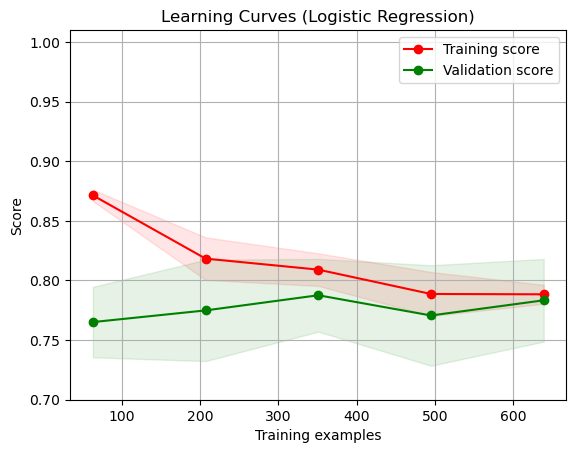

In [42]:
title = 'Learning Curves (Logistic Regression)'
cv = 10
plot_learning_curve(logreg, title, X_train, y_train, ylim = (0.7, 1.01), cv = cv, n_jobs = 1)

- The model doesn't overfit. As we can see, the curves converge and no gap between the training and the validation score exists in the last points of the curve.
- The model underfits. Our final score is about 0.786. For now, it's just an toy model.

In [44]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim = None, cv = None):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Parameter')
    plt.ylabel('Score')
    plt.xscale('log')
    
    train_scores, test_scores = validation_curve(estimator, X, y, param_name = param_name,
                                                 param_range = param_range, cv = cv)
    
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    plt.grid()
    
    
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')
    
    plt.plot(param_range, train_mean, color = 'r', marker = 'o', markersize = 5, label = 'Training score')
    plt.plot(param_range, test_mean, color = 'g', linestyle = '--', marker = 's', markersize = 5, label = 'Validation score')
    
    plt.legend(loc = 'best')

    return plt

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/matplotlib/pyplot.py'>

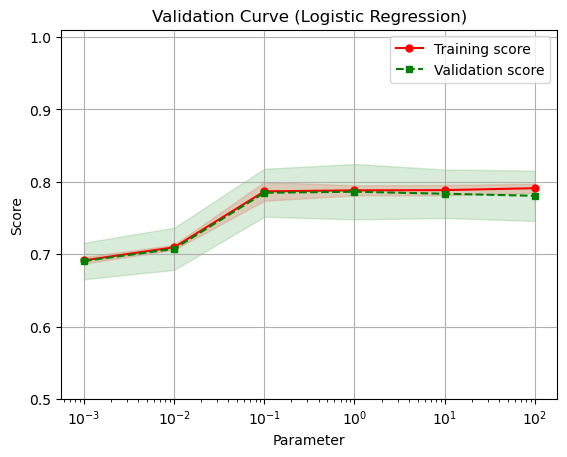

In [45]:
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
cv = 10
plot_validation_curve(estimator = logreg, title = title , X = X_train, y = y_train, param_name = param_name,
                      param_range = param_range, ylim = (0.5, 1.01), cv = cv)

The figure shows that there is no huge difference in model's performance for this C values. In a logistic regression, C is the only model parameter that we can change.

# 2. Deep analysis

According to the metric our model has a room of improvement. This can be done by:

- Improving the way how we handled 'Age' missing data. We decided to replace missing data by a unique value, but now we can go deeper and search for a better imputation strategy.
- Exploring data to understand which features can have impact in the model and how they can be manipulated to boost that impact.
- Building new features that can increase the predictive power of our model.

Now our aim is to improve the model performance just by the data quality, i.e., enriching our data.

In [46]:
df = df_org.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [48]:
df.drop(['SibSp','Parch'], axis = 1, inplace = True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,0


In [49]:
df.drop(['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,1,0,3,male,22.0,7.2500,S,1
1,2,1,1,female,38.0,71.2833,C,1
2,3,1,3,female,26.0,7.9250,S,0
3,4,1,1,female,35.0,53.1000,S,1
4,5,0,3,male,35.0,8.0500,S,0


### Imputation of 'Age' missing data

The initial approach to estimate 'Age' missing values was to fill with a placeholder value (1000). One way to improve the imputation method is to estimate the missing values based on known relationships. In our case, we can do this by using the information in the variable 'Name'. Looking to 'Name' values, we can see person's name and title. Person's title is a relevant information to estimate ages.

The steps to implement this imputation method are:

- Extract titles from 'Name'.
- Plot a figure with both features and confirm that there is a connection between titles and age.
- For each title, get people's average age and use it to fill missing values.

In [50]:
df_org['Name'].unique()[:10]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)'], dtype=object)

The rule seems to be: 'last name' + ',' + 'title' + 'other names'

In [51]:
df['Titles'] = 0
df['Titles'] = df_org['Name'].str.extract('([A-Za-z]+)\.', expand = False)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Titles
0,1,0,3,male,22.0,7.2500,S,1,Mr
1,2,1,1,female,38.0,71.2833,C,1,Mrs
2,3,1,3,female,26.0,7.9250,S,0,Miss
3,4,1,1,female,35.0,53.1000,S,1,Mrs
4,5,0,3,male,35.0,8.0500,S,0,Mr


In [52]:
df['Titles'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

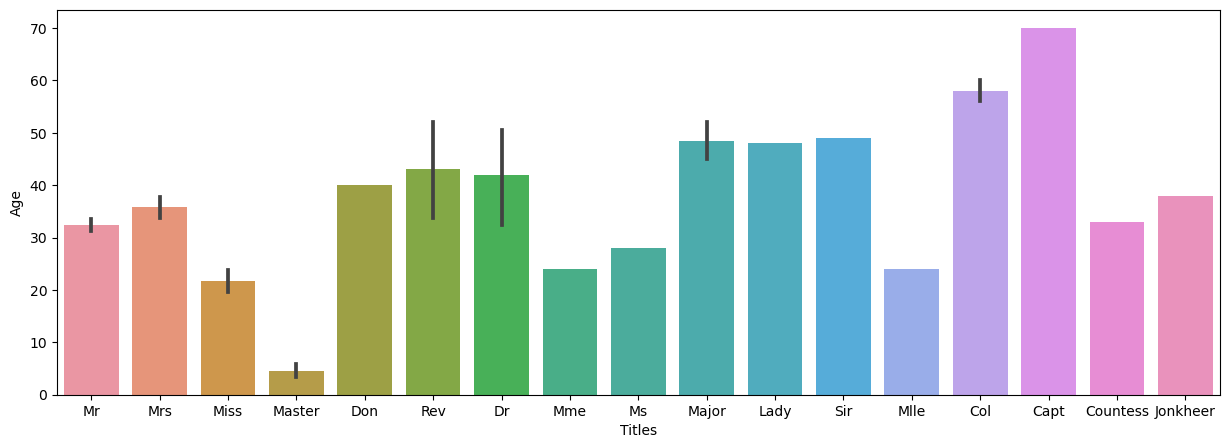

In [53]:
plt.figure(figsize = (15,5))
sns.barplot( x = df['Titles'], y = df_org['Age'])
plt.show()

Apart from Rev and Dr, which have a larger error bar, the mean value seems to accurately represent the data of all the other features. 

In [54]:
df_org['Titles'] = df['Titles']
means = df_org.groupby('Titles')['Age'].mean()
means.head()

Titles
Capt        70.0
Col         58.0
Countess    33.0
Don         40.0
Dr          42.0
Name: Age, dtype: float64

In [55]:
map_means = means.to_dict()
map_means

{'Capt': 70.0,
 'Col': 58.0,
 'Countess': 33.0,
 'Don': 40.0,
 'Dr': 42.0,
 'Jonkheer': 38.0,
 'Lady': 48.0,
 'Major': 48.5,
 'Master': 4.574166666666667,
 'Miss': 21.773972602739725,
 'Mlle': 24.0,
 'Mme': 24.0,
 'Mr': 32.368090452261306,
 'Mrs': 35.898148148148145,
 'Ms': 28.0,
 'Rev': 43.166666666666664,
 'Sir': 49.0}

In [56]:
idx_nan_age = df.loc[np.isnan(df['Age'])].index
df.loc[idx_nan_age, 'Age'] = df['Titles'].loc[idx_nan_age].map(map_means)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Titles
0,1,0,3,male,22.0,7.2500,S,1,Mr
1,2,1,1,female,38.0,71.2833,C,1,Mrs
2,3,1,3,female,26.0,7.9250,S,0,Miss
3,4,1,1,female,35.0,53.1000,S,1,Mrs
4,5,0,3,male,35.0,8.0500,S,0,Mr


In [57]:
df['Imputed'] = 0
df.loc[idx_nan_age, 'Imputed'] = 1
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Titles,Imputed
0,1,0,3,male,22.0,7.2500,S,1,Mr,0
1,2,1,1,female,38.0,71.2833,C,1,Mrs,0
2,3,1,3,female,26.0,7.9250,S,0,Miss,0
3,4,1,1,female,35.0,53.1000,S,1,Mrs,0
4,5,0,3,male,35.0,8.0500,S,0,Mr,0


## Exploratory Data Anaysis (EDA)

We have to do a heavy data analysis process but we don't want get lost in it. To avoid this we are going to follow a hypothesis driven approach. The hypothesis driven approach consists in establishing hypothesis about the variables behaviour and their relationships, early in the process, to then focus on using data to prove (or disprove) those hypothesis. This makes our analysis very objective because we will be collecting just enough data to test specific hypothesis. 

We will start by listing each of the variables and generate hypothesis about their relationship with the target variable ('Survived'). Then, we will test those hypothesis through a set of exploratory data analysis tools. As a result, we'll end up with a comprehensive view about the variables that should belong to our prediction model.

- **PassengerId.** This is just an unique identification of each passenger. It's not expected to be relevant to the analysis.
- **Survived.** Target variable. 
- **Pclass.** This is the ticket class. First class should have a higher survival rate.
- **Name.** Names are accompanied by a title. As a consequence, it can lead to different forms of treatment. 
- **Sex.** This shuld important. Women are usually evacuated first in a disaster.
- **Age.** Same as sex. Children also are usually evacuated first in a disaster.
- **SibSp.** Number of siblings/spouses aboard the Titanic. I'd say that it's easier to survive if you're travelling alone than if you're with your family.
- **Parch.** Number of parents/children aboard the Titanic. It should play with 'SibSp'.
- **Ticket.** This is the ticket number. Unless it has some information about places, it shouldn't be important for prediction purposes.
- **Fare.** Same logic as 'Pclass'.
- **Cabin.** The cabin number can indicate where people were during the disaster. It wouldn't be surprising if it had some influence in survival chances, but this variable was excluded due to the high percentage of missing values.
- **Embarked.** It's not expectable that people coming from Cherbourg are more unlucky than people coming from Southampton. I would say that this variable is not too important.

### PClass

Our hypothesis is that the higher the class, the higher the chances of survival. This means that a person travelling in the first class has a higher chance of survival than a person traveling on the second or third class.

<AxesSubplot: xlabel='Pclass', ylabel='Survived'>

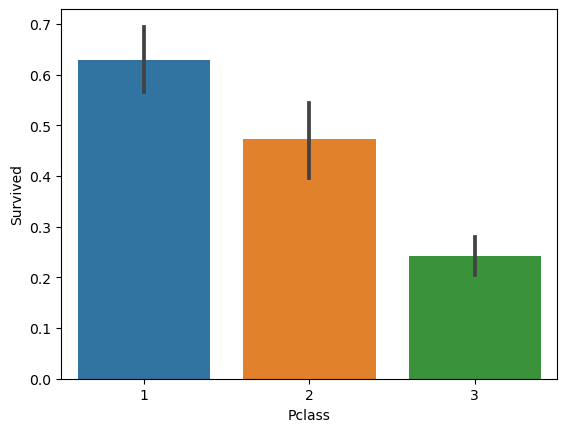

In [58]:
sns.barplot(x = df['Pclass'], y = df['Survived'])

As we can see, about 60% of the people travelling in the first class survived. In contrast, only approximately 25% of the people travelling in the third class survived. Accordingly, this plot suggests that the class in which people travel affects the chances of survival.

### Name/Titles

Our assumption is that people's title influences how they are treated. In our case, we have several titles, but only some of them are shared by a significant number of people. 

Let's analyse the title and see if we can can find a sensible way to group them.

In [59]:
df.groupby('Titles')['PassengerId'].count()

Titles
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
Name: PassengerId, dtype: int64

We can see that:

- Titles like 'Master', 'Miss', 'Mr', and 'Mrs', appear several times. Accordingly, we will not group them.
- Regarding Mme and Mlle, we can see here that they correspond to the categories Mrs and Miss, respectively. As a consequence, we will assign them to those titles.
- Finally, we will group all the other titles in a new title named 'Other'. Then, we will define 'Title' as a categorical feature and plot it to see how it looks like. 

In [60]:
titles_dict = {'Capt': 'Other',
               'Major': 'Other',
               'Jonkheer': 'Other',
               'Don': 'Other',
               'Sir': 'Other',
               'Dr': 'Other',
               'Rev': 'Other',
               'Countess': 'Other',
               'Dona': 'Other',
               'Mme': 'Mrs',
               'Mlle': 'Miss',
               'Ms': 'Miss',
               'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Master',
               'Lady': 'Other'}

In [61]:
df['Titles'] = df['Titles'].map(titles_dict)
df['Titles'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Titles, dtype: object

In [62]:
df['Titles'] = pd.Categorical(df['Titles'])
df.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Sex              object
Age             float64
Fare            float64
Embarked         object
FamilySize        int64
Titles         category
Imputed           int64
dtype: object

<AxesSubplot: xlabel='Titles', ylabel='Survived'>

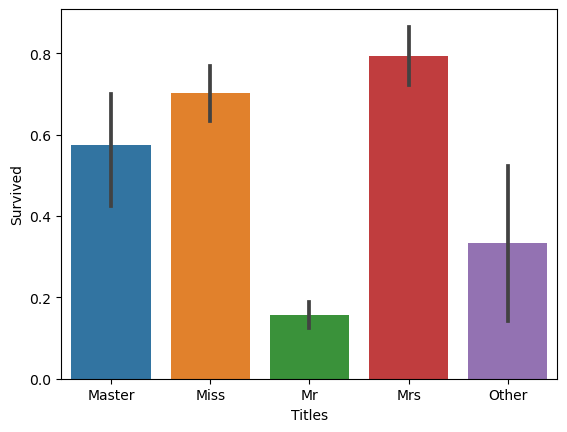

In [63]:
sns.barplot(x = df['Titles'], y = df['Survived'])

The results suggest that:

- People with the title 'Mr' survived less than people with any other title.
- Titles with a survival rate higher than 50% are those that correspond to female (Miss or Mrs) or children (Master) titles.
- The new category, 'Other', should be more discretized. As we can see by the error bar, there is a significant uncertainty around the mean value. Probably, one of the problems is that we are mixing male and female titles in the 'Other' category. Also, the category 'Master' seems to have a similar problem. We will keep these two situations in our mind for future improvement of our data set.

### Sex

We already have seen that women had a higher survival rate. But, let's make a plot to make sure what's going on.

In [64]:
df['Sex'] = pd.Categorical(df['Sex'])

<AxesSubplot: xlabel='Sex', ylabel='Survived'>

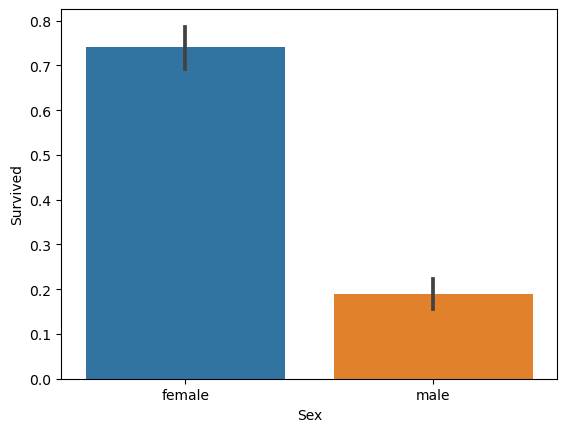

In [65]:
sns.barplot(x = df['Sex'], y = df['Survived'])

The hypothesis seems to be right.

### Age

The hypothesis is that children are more prone to survive than adult people. About elders we can consideren they are the most vulnerable, so this can play for both sides: either people help elders because they are more vulnerable, or they they are not able to cope with the challenges posed by the wreck of a ship.

Let's do  a bar plot to help us understanding the situation.

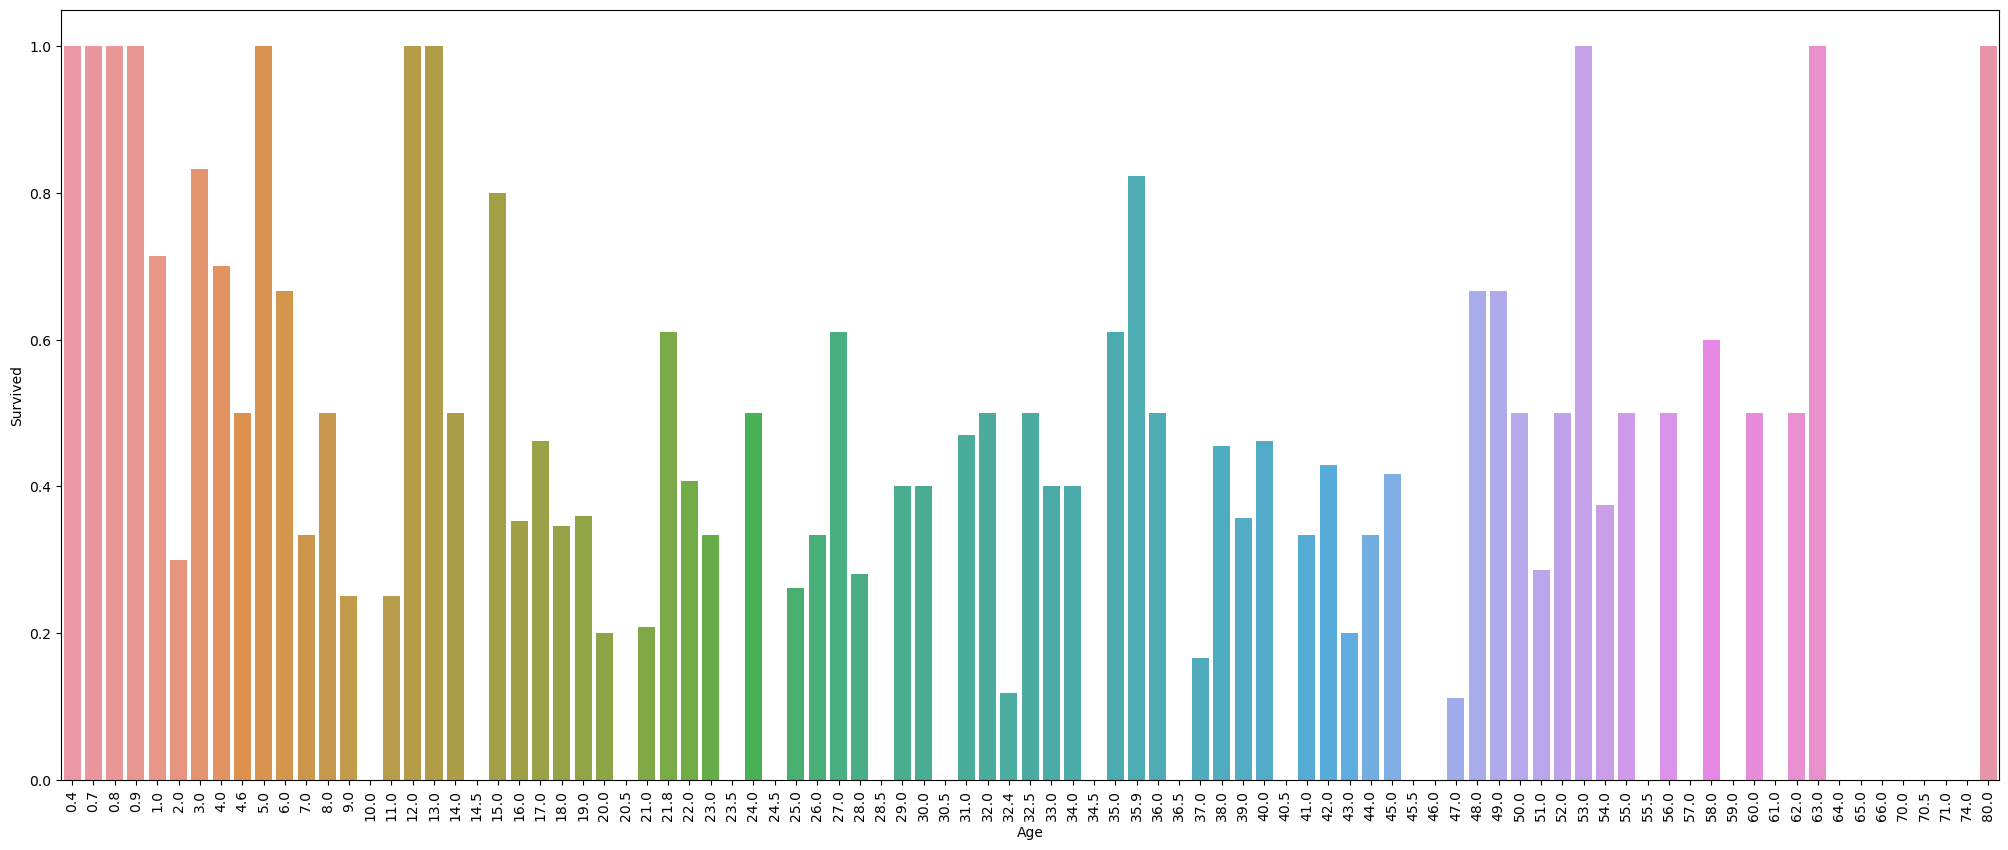

In [66]:
plt.figure(figsize = (25,10))
sns.barplot(x = df['Age'].round(1), y = df['Survived'], errorbar = ('ci', False))
plt.xticks(rotation = 90)
plt.show()

Not being totaly objetive we can say that the plot has three regions:

- One region that goes between age 0 and 15;
- One between age 15 and 48;
- A last one between age 48 and 80.

This division is arguable. However, this categories split fits into: childrens, adults and elders. For now, let's proceed this way.

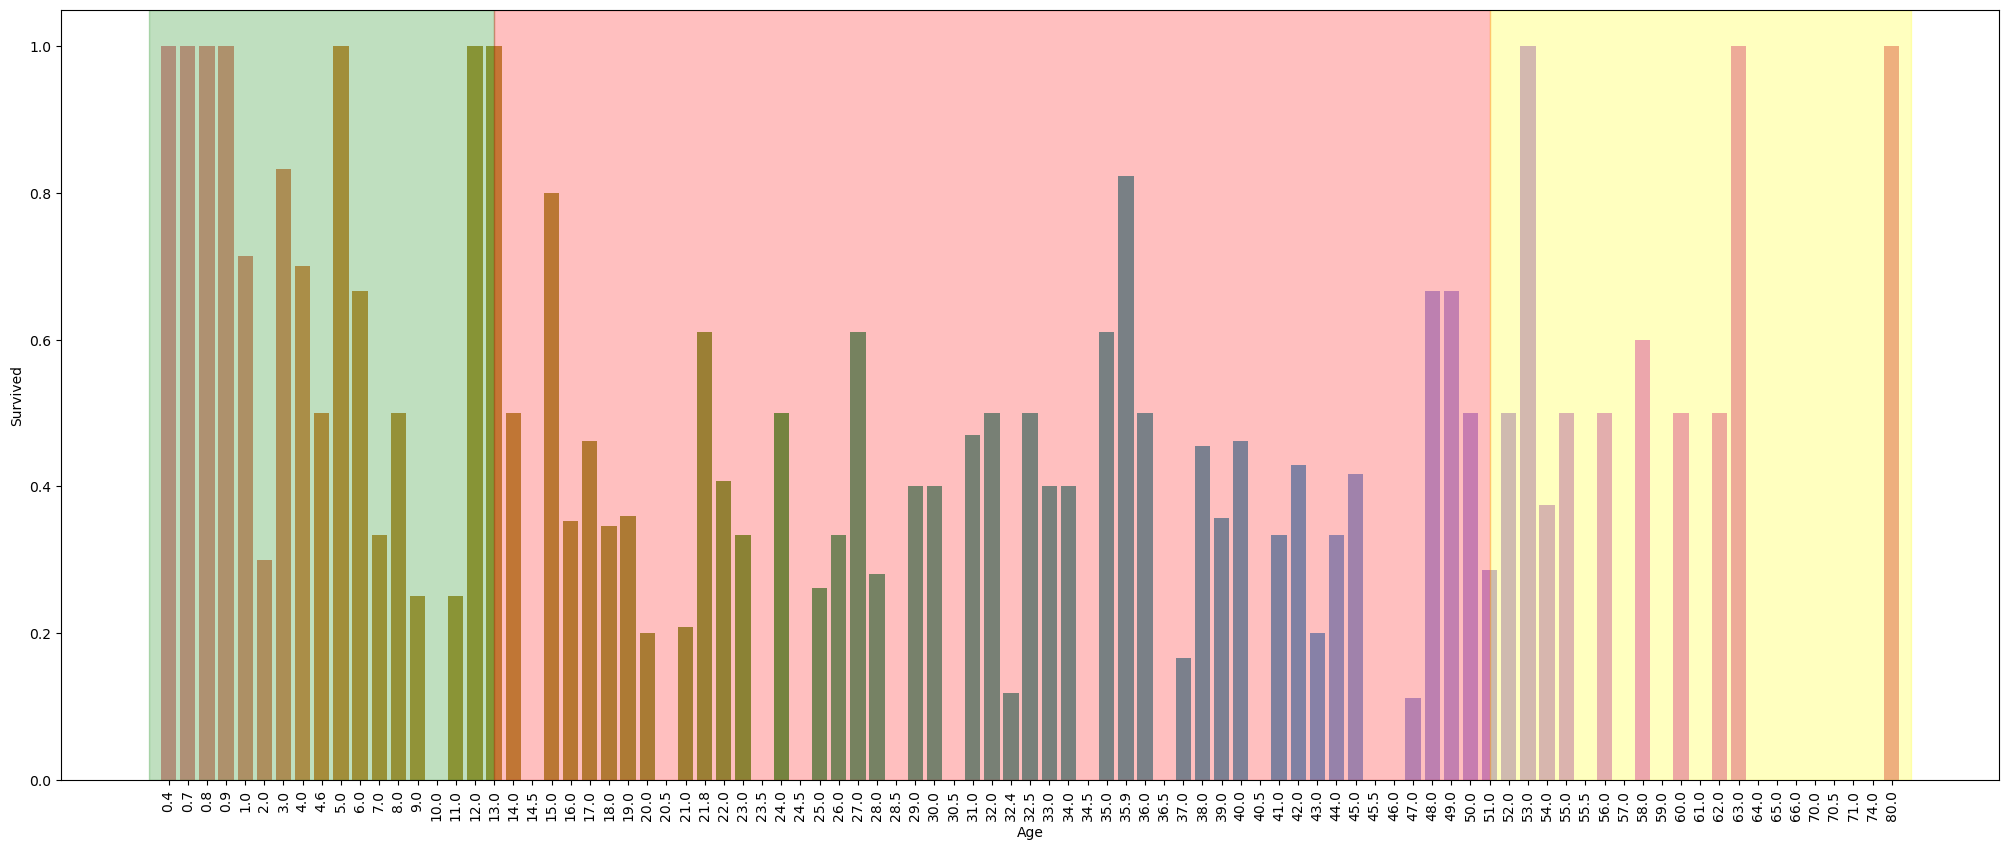

In [69]:
limit_1 = 12
limit_2 = 50

x_limit_1 = np.size(df[df['Age'] < limit_1]['Age'].unique())
x_limit_2 = np.size(df[df['Age'] < limit_2]['Age'].unique())

plt.figure(figsize = (25,10))
sns.barplot(x = df['Age'].round(1), y = df['Survived'], errorbar = ('ci', False))

plt.axvspan(-1, x_limit_1, alpha = 0.25, color = 'green')
plt.axvspan(x_limit_1, x_limit_2, alpha = 0.25, color = 'red')
plt.axvspan(x_limit_2, 91, alpha = 0.25, color = 'yellow')

plt.xticks(rotation = 90)
plt.show()

In [70]:
df['Age'] = pd.cut(df['Age'], bins = [0, 12, 50, 200], labels = ['Child', 'Adult', 'Elder'])
df['Age'].head()

0    Adult
1    Adult
2    Adult
3    Adult
4    Adult
Name: Age, dtype: category
Categories (3, object): ['Child' < 'Adult' < 'Elder']

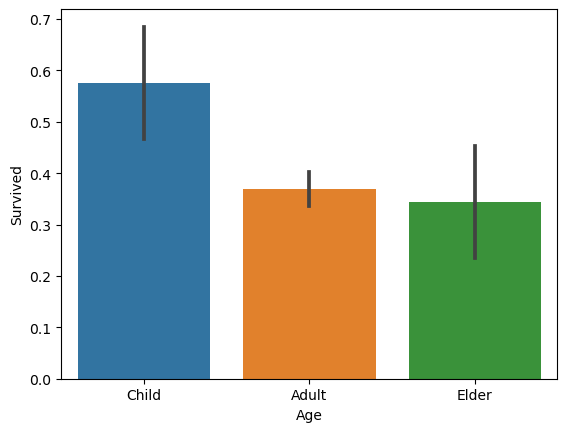

In [71]:
sns.barplot(x = df['Age'], y = df['Survived'])
plt.show()

The plot shows that children have a higher survival rate. It also shows that, in terms of survival, there is not a significant difference between the categories 'Adult' and 'Elder'. It seems that it would be enough to just distinguish between children and adults but for now, we will not make any change.

### FamilySize

Regarding family size, the hypothesis is that those who travel alone, have a higher survival rate. The idea is that people without family don't have to worry for others than themselves.

Again, let's make a bar plot.

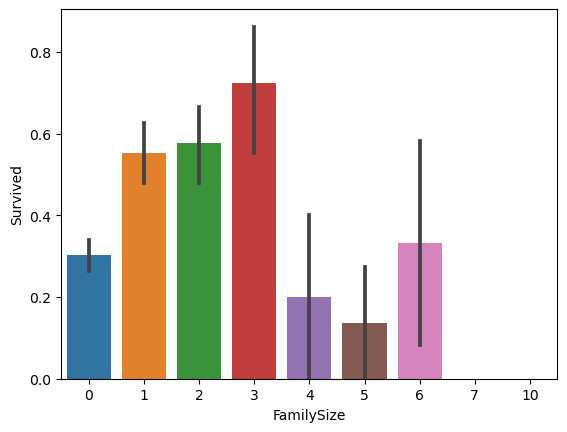

In [72]:
sns.barplot(x = df['FamilySize'], y = df['Survived'])
plt.show()

As we can see, when 'FamilySize' is between 0 and 3, the hypothesis isn't seem correct. People that are travelling alone have a lower survival rate than people who are travelling with one, two or three people more. However, when FamilySize is between 4 and 10, things start to change. 

This variable seems to be more complex than expected. Accordingly, we will leave it as a continuous variable to preserve all the information it has.

### Fare

The same logic applied to 'Pclass' should work for 'Fare': higher fares, higher survival rate.

Since now we want to establish comparisons across different levels of a categorical variable, we will use a box plot instead of a bar plot.

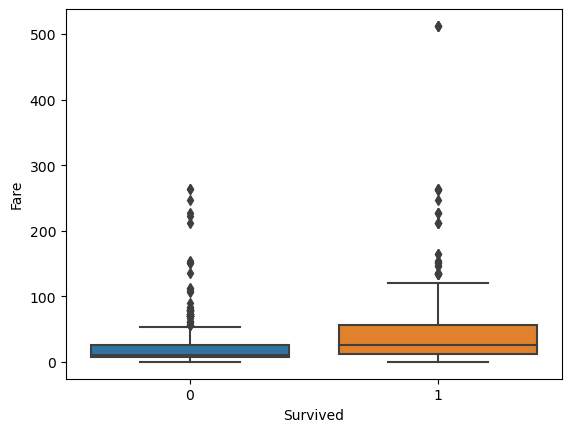

In [73]:
sns.boxplot(y = df['Fare'], x = df['Survived'])
plt.show()

The plot suggests that those who survived paid a higher fare. Since we believe this variable is connected with 'Pclass', let's plot them together.

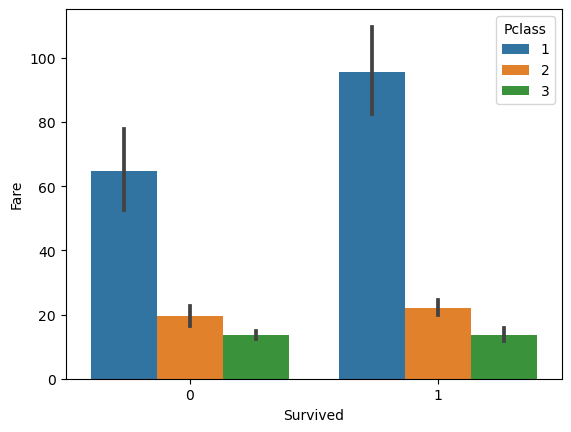

In [75]:
sns.barplot(x = df['Survived'], y = df['Fare'], hue = df['Pclass'])
plt.show()

It seems that 'Fare' doesn't make difference, in terms of survival, if you are travelling in second or third class. However, if you are travelling in first class, the higher the fare, the higher the chances of survival. Considering this, it would make sense to create interaction features between 'Fare' and 'Pclass'.

### Embarked

The hypothesis regarding 'Embarked' is that it doesn't influence the chances of survival.  

Let's do a plot.

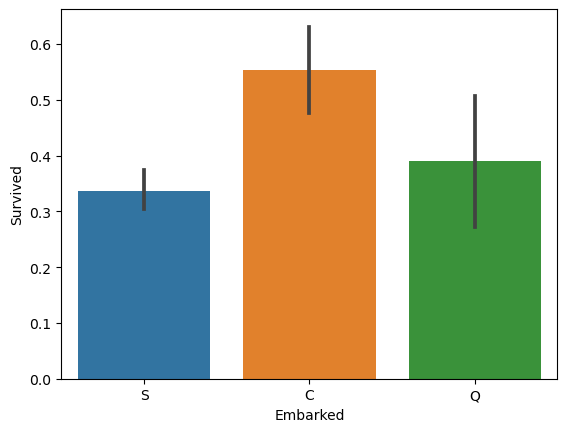

In [76]:
sns.barplot(x = df['Embarked'], y = df['Survived'])
plt.show()

This is strange and may be hidding some relationship that is not obvious with this plot (e.g. people embarking on C were mostly women). Let's dive deeper.

In [77]:
df.groupby('Embarked').mean()

,PassengerId,Survived,Pclass,Fare,FamilySize,Imputed
Embarked,,,,,,
C,445.357143,0.553571,1.886905,59.954144,0.750000,0.226190
Q,417.896104,0.389610,2.909091,13.276030,0.597403,0.636364
S,449.527950,0.336957,2.350932,27.079812,0.984472,0.139752


It seems that people embarking on C were paying more and travelling in a better class than people embarking on Q and S.

In [78]:
df.groupby(['Embarked','Age'])['PassengerId'].count()

Embarked  Age  
C         Child     13
          Adult    140
          Elder     15
Q         Child      4
          Adult     70
          Elder      3
S         Child     56
          Adult    543
          Elder     45
Name: PassengerId, dtype: int64

No significant differences can be found.

In [80]:
df.groupby(['Embarked','Sex'])['PassengerId'].count()

Embarked  Sex   
C         female     73
          male       95
Q         female     36
          male       41
S         female    203
          male      441
Name: PassengerId, dtype: int64

Considering the results above, what really seems to be influencing is the class where people were travelling and how much they were spending so the embarkment point doesn't influence the survival rate

For now, we will not delete the variable because t's a bit of a biased conclusion. However, let's keep in mind that maybe 'Embarked' doesn't affect 'Survived'.

## Feature extraction

Feature extraction addresses the problem of attaining the most informative and compact set of features, to improve the performance of machine learning models.

**Informative** means that we are looking for features that can characterize the behaviour of what we are trying to model. Regarding **compact**, what we mean is that we want to exclude irrelevant features from our model. There are several reasons to exclude irrelevant features, the most important is to reduce overfitting. 

These two main issues are addressed two sub-sections:

- **Feature engineering**, which is related to the generation of informative features
- **Feature selection**, which regards the choice of a compact set of features.

### Feature engineering

We want to convert raw data into useful features. There are several feature engineering techniques we can apply. In our case we will use just two techniques:

- Box-Cox transformations (Box & Cox 1964);
- Polynomials generation through non-linear expansions.

Before the application of these techniques, we will just make some adjustments to the data, in order to prepare it for the modelling process.

#### Data preparation

In [81]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Titles,Imputed
0,1,0,3,male,Adult,7.2500,S,1,Mr,0
1,2,1,1,female,Adult,71.2833,C,1,Mrs,0
2,3,1,3,female,Adult,7.9250,S,0,Miss,0
3,4,1,1,female,Adult,53.1000,S,1,Mrs,0
4,5,0,3,male,Adult,8.0500,S,0,Mr,0


In [82]:
df.drop('PassengerId', axis = 1, inplace = True)

In [83]:
df.dtypes

Survived         int64
Pclass           int64
Sex           category
Age           category
Fare           float64
Embarked        object
FamilySize       int64
Titles        category
Imputed          int64
dtype: object

In [84]:
df['Embarked'] = pd.Categorical(df['Embarked'])
df['Pclass'] = pd.Categorical(df['Pclass'])
df.dtypes

Survived         int64
Pclass        category
Sex           category
Age           category
Fare           float64
Embarked      category
FamilySize       int64
Titles        category
Imputed          int64
dtype: object

In [85]:
df = pd.get_dummies(df, drop_first = 1)
df.head()

,Survived,Fare,FamilySize,Imputed,Pclass_2,Pclass_3,Sex_male,Age_Adult,Age_Elder,Embarked_Q,Embarked_S,Titles_Miss,Titles_Mr,Titles_Mrs,Titles_Other
0,0,7.2500,1,0,0,1,1,1,0,0,1,0,1,0,0
1,1,71.2833,1,0,0,0,0,1,0,0,0,0,0,1,0
2,1,7.9250,0,0,0,1,0,1,0,0,1,1,0,0,0
3,1,53.1000,1,0,0,0,0,1,0,0,1,0,0,1,0
4,0,8.0500,0,0,0,1,1,1,0,0,1,0,1,0,0


In [86]:
X = df[df.loc[:, df.columns != 'Survived'].columns]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### Box-Cox transformations

Box-Cox transformations aim to normalize variables. These transformations are an alternative to the typical transformations, such as square root transformations, log transformations, and inverse transformations. The main advantage of Box-Cox transformations is that they optimally normalize the chosen variable. Thus, they avoid the need to randomly try different transformations and automatize the data transformation process.

In [88]:
X_train_transformed = X_train.copy()
X_train_transformed['Fare'] = boxcox(X_train_transformed['Fare'] + 1)[0]
X_test_transformed = X_test.copy()
X_test_transformed['Fare'] = boxcox(X_test_transformed['Fare'] + 1)[0]

#### Polynomials

One standard way to enrich our set of features is to generate polynomials. Polynomial expansion creates interactions between features, as well as creates powers. This way we introduce a nonlinear dimension to our data set, which can improve the predictive power of our model.

We should scale our features when we have polynomial or interaction terms in our model. These terms tend to produce multicollinearity, which can make our estimates very sensitive to minor changes in the model. Scaling features to a range allow us to reduce multicollinearity and its problems.

To scale the features, we will transform the data so that it lies between a given minimum and maximum value. We will follow the common practice and say that our minimum value is zero, and our maximum value is one.

In [89]:
scaler = MinMaxScaler()

X_train_transformed_scaled = scaler.fit_transform(X_train_transformed)
X_test_transformed_scaled = scaler.transform(X_test_transformed)

In [90]:
poly = PolynomialFeatures(degree = 2).fit(X_train_transformed)
X_train_poly = poly.transform(X_train_transformed_scaled)
X_test_poly = poly.transform(X_test_transformed_scaled)

In [91]:
print(poly.get_feature_names_out())

['1' 'Fare' 'FamilySize' 'Imputed' 'Pclass_2' 'Pclass_3' 'Sex_male'
 'Age_Adult' 'Age_Elder' 'Embarked_Q' 'Embarked_S' 'Titles_Miss'
 'Titles_Mr' 'Titles_Mrs' 'Titles_Other' 'Fare^2' 'Fare FamilySize'
 'Fare Imputed' 'Fare Pclass_2' 'Fare Pclass_3' 'Fare Sex_male'
 'Fare Age_Adult' 'Fare Age_Elder' 'Fare Embarked_Q' 'Fare Embarked_S'
 'Fare Titles_Miss' 'Fare Titles_Mr' 'Fare Titles_Mrs' 'Fare Titles_Other'
 'FamilySize^2' 'FamilySize Imputed' 'FamilySize Pclass_2'
 'FamilySize Pclass_3' 'FamilySize Sex_male' 'FamilySize Age_Adult'
 'FamilySize Age_Elder' 'FamilySize Embarked_Q' 'FamilySize Embarked_S'
 'FamilySize Titles_Miss' 'FamilySize Titles_Mr' 'FamilySize Titles_Mrs'
 'FamilySize Titles_Other' 'Imputed^2' 'Imputed Pclass_2'
 'Imputed Pclass_3' 'Imputed Sex_male' 'Imputed Age_Adult'
 'Imputed Age_Elder' 'Imputed Embarked_Q' 'Imputed Embarked_S'
 'Imputed Titles_Miss' 'Imputed Titles_Mr' 'Imputed Titles_Mrs'
 'Imputed Titles_Other' 'Pclass_2^2' 'Pclass_2 Pclass_3'
 'Pclass_2 Sex_m

### Feature selection

Feature selection is about chosing the relevant information. It is good to add and generate features, but at some point we need to exclude irrelevant features. Otherwise, we will be penalizing the predictive power of our model. 

In this work, we will use a univariate statistics approach. This approach selects features based on univariate statistical tests between each feature and the target variable. The intuition is that features that are independent from the target variable, are irrelevant for classification.

We will use the chi-squared test for feature selection. This means that we have to choose the number of features that we want in the model. For example, if we want to have three features in our model, the method will select the three features with highest $\chi^2$ score.

Since we don't know the ideal number of features, we will test the method with all the possible number of features and choose the number of features with better performance.

#### Univariate statistics

In [95]:
logreg = LogisticRegression(C = 1)
logreg.fit(X_train, y_train)
scores = cross_val_score(logreg, X_train, y_train, cv = 10)
print('CV accuracy (original): %.3f +/- %.3f \n' % (np.mean(scores), np.std(scores)))
highest_score = np.mean(scores)

for i in range(1,X_train_poly.shape[1]+1, 1):
    select = SelectKBest(score_func = chi2, k = i)
    select.fit(X_train_poly, y_train)
    X_train_poly_selected = select.transform(X_train_poly)

    logreg.fit(X_train_poly_selected, y_train)
    scores = cross_val_score(logreg, X_train_poly_selected, y_train, cv=10)
    print('CV accuracy (number of features = %i): %.3f +/- %.3f' % (i, np.mean(scores), np.std(scores)))
    
    if np.mean(scores) > highest_score:
        highest_score = np.mean(scores)
        std = np.std(scores)
        k_features_highest_scores = i
    elif np.mean(scores) == highest_score:
        if np.std(scores) < std:
            highest_score = np.mean(scores)
            std = np.std(scores)
            k_features_highest_score = i
    else:
        print('The original is better \n')

CV accuracy (original): 0.827 +/- 0.030 

CV accuracy (number of features = 1): 0.789 +/- 0.046
The original is better 

CV accuracy (number of features = 2): 0.789 +/- 0.046
The original is better 

CV accuracy (number of features = 3): 0.789 +/- 0.046
The original is better 

CV accuracy (number of features = 4): 0.789 +/- 0.046
The original is better 

CV accuracy (number of features = 5): 0.788 +/- 0.044
The original is better 

CV accuracy (number of features = 6): 0.788 +/- 0.044
The original is better 

CV accuracy (number of features = 7): 0.789 +/- 0.046
The original is better 

CV accuracy (number of features = 8): 0.789 +/- 0.045
The original is better 

CV accuracy (number of features = 9): 0.789 +/- 0.045
The original is better 

CV accuracy (number of features = 10): 0.787 +/- 0.042
The original is better 

CV accuracy (number of features = 11): 0.787 +/- 0.042
The original is better 

CV accuracy (number of features = 12): 0.796 +/- 0.036
The original is better 

CV accu

CV accuracy (number of features = 103): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 104): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 105): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 106): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 107): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 108): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 109): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 110): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 111): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 112): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 113): 0.826 +/- 0.035
The original is better 

CV accuracy (number of features = 114): 0.826 +/- 0.035
The original is better 

CV accuracy (number of featu

Supricely the best score come from the logistic regression over the non transform data. Sometimes keep the things simple is the best, I guess.

# 3. The good model

Apparently we did an excellent work enriching our data. The enough to have a improved model and use it as our good model.

In [97]:
logreg = LogisticRegression(C = 1)
logreg.fit(X_train, y_train)
scores = cross_val_score(logreg, X_train, y_train, cv = 10)
print('CV accuracy: %.3f +/- %.3f \n' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.827 +/- 0.030 



## Learning Curve

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/matplotlib/pyplot.py'>

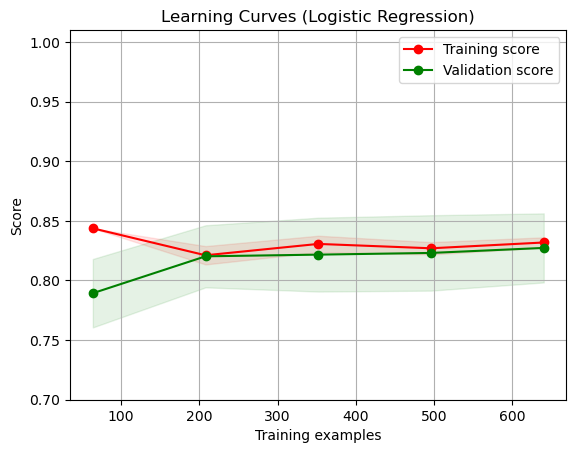

In [99]:
title = 'Learning Curves (Logistic Regression)'
cv = 10
plot_learning_curve(logreg, title, X_train, y_train, ylim = (0.7, 1.01), cv = cv, n_jobs = 1)

No signs of overfitting or underfitting.

## Validation curve

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/matplotlib/pyplot.py'>

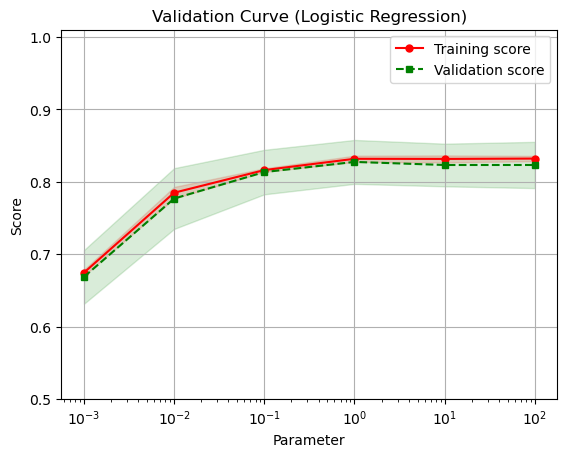

In [100]:
title = 'Validation Curve (Logistic Regression)'
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
cv = 10
plot_validation_curve(estimator = logreg, title = title , X = X_train, y = y_train, param_name = param_name,
                      param_range = param_range, ylim = (0.5, 1.01), cv = cv)

We used C=1 and the model performs well.

## Predictions

In [101]:
df = pd.read_csv('test.csv')
df_org = df.copy()

### Transforming data

In [103]:
df['FamilySize'] = df['SibSp'] + df['Parch']
df.drop('SibSp',axis=1,inplace=True)
df.drop('Parch',axis=1,inplace=True)
df.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)

df['Titles']=0
for i in df:
    df['Titles']=df_org['Name'].str.extract('([A-Za-z]+)\.', expand=False)  
df_org['Titles'] = df['Titles']  
means = df_org.groupby('Titles')['Age'].mean()
map_means = means.to_dict()
idx_nan_age = df.loc[np.isnan(df['Age'])].index
df.loc[idx_nan_age, 'Age'] = df['Titles'].loc[idx_nan_age].map(map_means)
df['Titles'] = df['Titles'].map(titles_dict)
df['Titles'] = pd.Categorical(df['Titles'])

df['Imputed'] = 0
df.loc[idx_nan_age, 'Imputed'] = 1

df['Age'] = pd.cut(df['Age'], bins=[0, 12, 50, 200], labels=['Child','Adult','Elder'])

passenger_id = df['PassengerId'].values
df.drop('PassengerId', axis=1, inplace=True)
df['Embarked'] = pd.Categorical(df['Embarked'])
df['Pclass'] = pd.Categorical(df['Pclass'])
df = pd.get_dummies(df, drop_first=1)

df = df.fillna(df.mean())  # There is one missing value in 'Fare'

X = df[df.loc[:, df.columns != 'Survived'].columns]

In [105]:
predictions = logreg.predict(X)

In [106]:
results = pd.DataFrame({'PassengerId' : passenger_id, 'Survived' : predictions})
results.to_csv('Results.csv', index = False)

# 4. Conclusion

The aim of this work was to get a good clasification model for this data. We did it improving data quality through exploratory data analysis and clever techniques. Although not all tools were useful they were a good practice for future projects. Because I think the best lesson of this work is that simple models and better data are the wining combination.